In [ ]:
!pip install datasets
!pip install rouge
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 41.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-n

In [ ]:
import torch
import pandas as pd
from rouge import Rouge
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')
# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

# the base Google Drive directory
root_dir = "/content/gdrive/MyDrive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/NLP_Project/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)
path = root_dir + project_folder

Mounted at /content/drive
Mounted at /content/gdrive

Your working directory was changed to /content/gdrive/MyDrive/Colab Notebooks/NLP_Project/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv(path + "datasets/hindi_train.csv")

In [ ]:
data

,Id,Heading,Summary,Article
0,hindi_2023_train_0,"गला दबाकर हत्या की; बॉडी बोरे में भरी, लोकल मा...",Kerala Minor Girl Rape Case - केरल के एर्नाकुल...,केरल के एर्नाकुलम जिले में 5 साल की बच्ची से र...
1,hindi_2023_train_1,तेलंगाना में 18 की जान गई; जम्मू-कश्मीर में बा...,इस साल मानसून सीजन में कई राज्यों में भारी तबा...,मानसून सीजन में हुई भारी बारिश ने कई राज्यों म...
2,hindi_2023_train_2,"राजस्थान सरकार बनाएगी कर्ज राहत आयोग, कोर्ट के...",चुनावी साल में राजस्थान सरकार किसानों को लुभान...,चुनावी साल में राजस्थान सरकार किसानों को लुभान...
3,hindi_2023_train_3,"3 से 7 अगस्त तक कर सकेंगे अप्लाय, प्राइस बैंड ...",Non-banking lender SBFC Finance's initial publ...,नॉन बैंकिग फाइनेंस कंपनी 'SBFC फाइनेंस लिमिटेड...
4,hindi_2023_train_4,"डाइनिंग टेबल पर कुकर-कड़ाही न सजाएं, चीन के खा...",स्वाद खाने की बुनियाद है। लेकिन अगर खाना सुंदर...,स्वाद खाने की बुनियाद है। लेकिन अगर खाना सुंदर...
...,...,...,...,...
21220,hindi_2022_11363,"MSP पर प्रधानमंत्री ने कमेटी बनाई, पराली जलाना...","कृषि मंत्री ने कहा, तीनों कृषि कानूनों को वापस...",नई दिल्ली: कृषि मंत्री नरेंद्र सिंह तोमर ने एम...
21221,hindi_2022_11364,"योगी सरकार ने 9 गेस्ट हाउस का नाम नदियों, धार्...",मुंबई में स्टेट गेस्ट हाउस अब यूपी स्टेट गेस्ट...,लखनऊ: उत्तर प्रदेश की योगी आदित्यनाथ सरकार ने ...
21222,hindi_2022_11365,"Coronavirus से कुछ राहत, 7 लाख के नीचे आए एक्ट...",केंद्रीय स्वास्थ्य मंत्रालय की तरफ से शुक्रवार...,नई दिल्ली। कोरोना वायरस को लेकर कुछ राहत की बा...
21223,hindi_2022_11366,"वाराणसी गंगा नदी के किनारे सबसे साफ शहर बना, प...",लोकसभा में इस शहर का प्रतिनिधित्व करने वाले प्...,नई दिल्ली: केंद्रीय शहरी विकास मंत्री हरदीप सि...


In [ ]:
# Remove rows with empty or whitespace-only entries in critical columns
data = data.dropna(subset=['Heading', 'Summary', 'Article'])  # Remove rows where any of these columns are NaN
data = data[data['Heading'].str.strip().astype(bool) & data['Summary'].str.strip().astype(bool) & data['Article'].str.strip().astype(bool)]

# Alternatively, to handle multiple text columns at once where any text field being empty should result in a row being dropped
text_columns = ['Heading', 'Summary', 'Article']
data = data.dropna(subset=text_columns)  # Drop rows where any specified columns are NaN
data = data[data[text_columns].apply(lambda x: x.str.strip().astype(bool)).all(axis=1)]

# Display the cleaned dataframe
data


,Id,Heading,Summary,Article
0,hindi_2023_train_0,"गला दबाकर हत्या की; बॉडी बोरे में भरी, लोकल मा...",Kerala Minor Girl Rape Case - केरल के एर्नाकुल...,केरल के एर्नाकुलम जिले में 5 साल की बच्ची से र...
1,hindi_2023_train_1,तेलंगाना में 18 की जान गई; जम्मू-कश्मीर में बा...,इस साल मानसून सीजन में कई राज्यों में भारी तबा...,मानसून सीजन में हुई भारी बारिश ने कई राज्यों म...
2,hindi_2023_train_2,"राजस्थान सरकार बनाएगी कर्ज राहत आयोग, कोर्ट के...",चुनावी साल में राजस्थान सरकार किसानों को लुभान...,चुनावी साल में राजस्थान सरकार किसानों को लुभान...
3,hindi_2023_train_3,"3 से 7 अगस्त तक कर सकेंगे अप्लाय, प्राइस बैंड ...",Non-banking lender SBFC Finance's initial publ...,नॉन बैंकिग फाइनेंस कंपनी 'SBFC फाइनेंस लिमिटेड...
4,hindi_2023_train_4,"डाइनिंग टेबल पर कुकर-कड़ाही न सजाएं, चीन के खा...",स्वाद खाने की बुनियाद है। लेकिन अगर खाना सुंदर...,स्वाद खाने की बुनियाद है। लेकिन अगर खाना सुंदर...
...,...,...,...,...
21220,hindi_2022_11363,"MSP पर प्रधानमंत्री ने कमेटी बनाई, पराली जलाना...","कृषि मंत्री ने कहा, तीनों कृषि कानूनों को वापस...",नई दिल्ली: कृषि मंत्री नरेंद्र सिंह तोमर ने एम...
21221,hindi_2022_11364,"योगी सरकार ने 9 गेस्ट हाउस का नाम नदियों, धार्...",मुंबई में स्टेट गेस्ट हाउस अब यूपी स्टेट गेस्ट...,लखनऊ: उत्तर प्रदेश की योगी आदित्यनाथ सरकार ने ...
21222,hindi_2022_11365,"Coronavirus से कुछ राहत, 7 लाख के नीचे आए एक्ट...",केंद्रीय स्वास्थ्य मंत्रालय की तरफ से शुक्रवार...,नई दिल्ली। कोरोना वायरस को लेकर कुछ राहत की बा...
21223,hindi_2022_11366,"वाराणसी गंगा नदी के किनारे सबसे साफ शहर बना, प...",लोकसभा में इस शहर का प्रतिनिधित्व करने वाले प्...,नई दिल्ली: केंद्रीय शहरी विकास मंत्री हरदीप सि...


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)

print("Training Set:")
print(train_data.head())
print("\nValidation Set:")
print(val_data.head())


Training Set:
                          Id  \
9479   hindi_2023_train_9479   
13586        hindi_2022_3729   
19938       hindi_2022_10081   
2879   hindi_2023_train_2879   
4325   hindi_2023_train_4325   

                                                 Heading  \
9479   कमजोर सीटों पर आएंगे मोदी-शाह, जानें कहां नया ...   
13586  अंबिका सोनी बोलीं- मेरे पास आया था ऑफर, सिख ही...   
19938  दोस्तों से भगवान कृष्ण से मुलाकात की इच्छा जता...   
2879   UK में भारतीय दूतावास पर तिरंगे का अपमान किया ...   
4325   बताया था जमाखोरी का खतरा; इच्छा नहीं होने पर भ...   

                                                 Summary  \
9479   Rajasthan Vidhan Sabha Election 2023 BJP Strat...   
13586  अंबिका सोनी ने बताया कि उन्हें सीएम पद के लिए ...   
19938  महिला का नाम टिटिआना ख्मेलोवस्क्या है, पासपोर्...   
2879   वारिस पंजाब दे मुखी अमृतपाल सिंह का हैंडलर और ...   
4325   2000 के नोट लाने के पक्ष में नहीं थे मोदी , बत...   

                                                 Article  
9479   विधान

In [ ]:
text = val_data['Article']
goldsummary = val_data['Summary']
id = val_data['Id']
article = val_data['Article']

In [ ]:
print(len(train_data))
print(len(val_data))

19101
2123


In [ ]:
train_data.to_csv(path + "datasets/my_train.csv", index=False)
val_data.to_csv(path + "datasets/my_val.csv", index=False)

In [ ]:
dataset = load_dataset('csv', data_files={'train': path + "datasets/my_train.csv", 'validation': path + "datasets/my_val.csv"})

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import torch

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/IndicBART")
model = AutoModelForSeq2SeqLM.from_pretrained("ai4bharat/IndicBART")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/832 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.90M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/221 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


pytorch_model.bin:   0%|          | 0.00/976M [00:00<?, ?B/s]

In [ ]:
def preprocess_data(examples):
    model_inputs = tokenizer(examples['Article'], max_length=1024, truncation=True, padding="max_length")

    # Set up the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['Summary'], max_length=128, truncation=True, padding="max_length")

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Tokenize all data
tokenized_datasets = dataset.map(preprocess_data, batched=True)


Map:   0%|          | 0/19101 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2123 [00:00<?, ? examples/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=4,
    num_train_epochs=4,
    predict_with_generate=True
)

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator
)


In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.562500,0.520035
2,0.514100,0.481661
3,0.504200,0.466327
4,0.490700,0.463126


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-defau

TrainOutput(global_step=19104, training_loss=0.6916847137150852, metrics={'train_runtime': 5397.5766, 'train_samples_per_second': 14.155, 'train_steps_per_second': 3.539, 'total_flos': 8.279061416430797e+16, 'train_loss': 0.6916847137150852, 'epoch': 4.0})

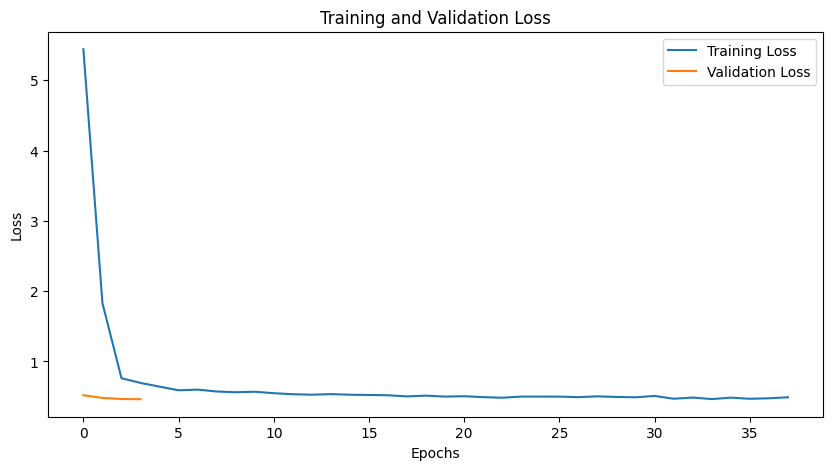

In [ ]:
import matplotlib.pyplot as plt

training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Define the path where you want to save your model and tokenizer
model_path = path + "models/IndicBART_FT_Hindi_news"

# Save the model and the tokenizer
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


('/content/gdrive/MyDrive/Colab Notebooks/NLP_Project/models/IndicBART_FT_Hindi_news/tokenizer_config.json',
 '/content/gdrive/MyDrive/Colab Notebooks/NLP_Project/models/IndicBART_FT_Hindi_news/special_tokens_map.json',
 '/content/gdrive/MyDrive/Colab Notebooks/NLP_Project/models/IndicBART_FT_Hindi_news/spiece.model',
 '/content/gdrive/MyDrive/Colab Notebooks/NLP_Project/models/IndicBART_FT_Hindi_news/added_tokens.json',
 '/content/gdrive/MyDrive/Colab Notebooks/NLP_Project/models/IndicBART_FT_Hindi_news/tokenizer.json')

In [ ]:
# Load the model and tokenizer
model_path = model_path
# tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/IndicBART")
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

# Check if CUDA is available and move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


OSError: /content/gdrive/MyDrive/Colab Notebooks/NLP_Project/ does not appear to have a file named config.json. Checkout 'https://huggingface.co//content/gdrive/MyDrive/Colab Notebooks/NLP_Project//tree/None' for available files.

In [ ]:
def summarize(text, max_length=150):
    # Encode the text input and send to the appropriate device
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True, padding="max_length").to('cuda')

    # Generate summary with the model
    model.eval()
    with torch.no_grad():
        summary_ids = model.generate(inputs['input_ids'], max_length=max_length, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example usage
article = dataset['validation'][0]['Article']  # Example using the first article
article = "Apurv is the greatest of all mortals alive on planet Earth!"
print("Generated Summary:", summarize(article))


Generated Summary: Apurv is the greatest of all mortals alive on planet Earth!


In [ ]:
from datasets import load_metric

rouge = load_metric("rouge")

def generate_summary(batch):
    inputs = tokenizer(batch['Article'], padding="max_length", truncation=True, max_length=1024, return_tensors="pt")
    outputs = model.generate(inputs.input_ids, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    batch['pred_summary'] = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return batch

# Apply the generate_summary function to the validation dataset
result = dataset['validation'].map(generate_summary, batched=True, batch_size=16)

# Now calculate the ROUGE scores
rouge_scores = rouge.compute(predictions=result['pred_summary'], references=dataset['validation']['Summary'])

print("ROUGE Scores:", rouge_scores)
